# Loan Prediction

> Part 1: Imports and Setup

First, I imported all the necessary Python libraries that I’ll need for this project. Pandas and NumPy will help me handle and manipulate the data, while Matplotlib and Seaborn will be used for visualization. I also imported all the scikit-learn modules I’ll need for preprocessing, model building, evaluation, and hyperparameter tuning. I set a fixed random seed to make my results reproducible so that every time I run the notebook, I’ll get the same results.

In [1]:
# Part 1: Imports and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import os

# Scikit-learn imports
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score, brier_score_loss, make_scorer, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# For reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


> Part 2: Load data

Next, I loaded the dataset into a pandas DataFrame and took a first look at it. I checked the first few rows with head(), examined the structure with info(), and got summary statistics with describe(). I also checked for missing values in all columns. I noticed there’s a 'name' column that identifies individuals, so I removed it since it doesn’t help the model and could compromise privacy.

In [2]:
# Part 2: Load data

# Download latest version
path = kagglehub.dataset_download("anishdevedward/loan-approval-dataset")
print("Path to dataset files:", path)
path = r"C:\Users\Musa\.cache\kagglehub\datasets\anishdevedward\loan-approval-dataset\versions\1"
os.listdir(path)
file_path = r"C:\Users\Musa\.cache\kagglehub\datasets\anishdevedward\loan-approval-dataset\versions\1\loan_approval.csv"
df = pd.read_csv(file_path)

# Initial inspection
print(df.head())
print("---"*10)
print(df.info())
print("---"*10)
print(df.describe())
print("---"*10)
print(df.isnull().sum())

# Drop obvious identifier columns
if 'name' in df.columns:
    df = df.drop(columns=['name'])

Path to dataset files: C:\Users\Musa\.cache\kagglehub\datasets\anishdevedward\loan-approval-dataset\versions\1
              name              city  income  credit_score  loan_amount  \
0     Allison Hill         East Jill  113810           389        39698   
1     Brandon Hall     New Jamesside   44592           729        15446   
2     Rhonda Smith      Lake Roberto   33278           584        11189   
3  Gabrielle Davis  West Melanieview  127196           344        48823   
4     Valerie Gray         Mariastad   66048           496        47174   

   years_employed  points  loan_approved  
0              27    50.0          False  
1              28    55.0          False  
2              13    45.0          False  
3              29    50.0          False  
4               4    25.0          False  
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 

> Part 3: Identify numeric and categorical columns

Here, I separated the columns into numeric and categorical features. This is important because numeric and categorical features need to be preprocessed differently. I made sure to remove the target column from the feature lists so it doesn’t accidentally get treated as input. This helps me clearly define which columns need scaling, imputation, or encoding later.

In [3]:
# Part 3: Identify numeric and categorical columns
target = 'loan_approved'  # adjust to your target column

num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object','category','bool']).columns.tolist()

# Remove target from feature lists if present
if target in num_cols: num_cols.remove(target)
if target in cat_cols: cat_cols.remove(target)

print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)

Numeric columns: ['income', 'credit_score', 'loan_amount', 'years_employed', 'points']
Categorical columns: ['city']


> Part 4: Preprocessing pipeline

I created a preprocessing pipeline to handle all the feature transformations in a clean and reproducible way. For numeric features, I impute missing values with the median and scale them using StandardScaler. For categorical features, I impute missing values with a constant placeholder ('missing') and one-hot encode them. I combined both transformers into a ColumnTransformer, so preprocessing happens automatically and consistently for both training and test sets.

In [4]:
# Part 4: Preprocessing pipeline
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

preprocessor = ColumnTransformer([
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
])

> Part 5: Train/test split

I split the dataset into training and test sets using stratified sampling. This ensures that the distribution of the target variable is consistent across both sets. The training set will be used to fit the model, and the test set will only be used for final evaluation. I also made sure to keep the random seed consistent for reproducibility.

In [6]:
# Part 5: Train/test split
X = df.drop(columns=[target])
y = df[target].astype(int)  # ensure 0/1

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=RANDOM_STATE
)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

Training set size: (1600, 6)
Test set size: (400, 6)


> Part 6: Model pipeline

I set up a RandomForestClassifier inside a pipeline that includes the preprocessing step. I chose Random Forest because it’s robust, handles both numeric and categorical data well, and can deal with imbalanced classes when using class_weight='balanced'. I used stratified 5-fold cross-validation to evaluate the model on the training data. I computed multiple metrics — F1, precision, recall, and ROC-AUC — to get a complete picture of model performance rather than relying on accuracy alone

In [21]:
# Part 6: Model pipeline
clf = Pipeline([
    ('pre', preprocessor),
    ('model', RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, class_weight='balanced'))
])

# Stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scoring = {
    'f1': make_scorer(f1_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'roc_auc': 'roc_auc'
}

# Cross-validation
cv_scores = cross_validate(clf, X_train, y_train, cv=cv, scoring=scoring, return_train_score=False, n_jobs=-1)
print({k: (v.mean(), v.std()) for k,v in cv_scores.items()})

{'fit_time': (0.6653315544128418, 0.018090157997428375), 'score_time': (0.06145567893981933, 0.007533238263118997), 'test_f1': (1.0, 0.0), 'test_precision': (1.0, 0.0), 'test_recall': (1.0, 0.0), 'test_roc_auc': (1.0, 0.0)}


> Part 7: Hyperparameter tuning with RandomizedSearchCV

To improve the model, I performed a randomized search over a set of hyperparameters. I tuned the number of trees (n_estimators), the maximum depth of each tree (max_depth), and the minimum number of samples required to split a node (min_samples_split). RandomizedSearchCV selects combinations of these parameters, performs cross-validation for each, and finds the combination that maximizes ROC-AUC. The best model is then stored for evaluation on the test set

In [22]:
# Part 7: Hyperparameter tuning with RandomizedSearchCV
param_dist = {
    'model__n_estimators': [100, 200, 500],
    'model__max_depth': [None, 5, 10, 20],
    'model__min_samples_split': [2, 5, 10]
}

search = RandomizedSearchCV(
    clf,
    param_distributions=param_dist,
    n_iter=8,
    cv=cv,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
search.fit(X_train, y_train)

print("Best ROC-AUC:", search.best_score_)
print("Best params:", search.best_params_)

best_model = search.best_estimator_

C:\Users\Musa\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Best ROC-AUC: 1.0
Best params: {'model__n_estimators': 500, 'model__min_samples_split': 10, 'model__max_depth': 20}


> Part 8: Evaluation on the test set

Finally, I evaluated the best model on the test set that was held out from training. I predicted both class labels and probabilities. I used a classification report and confusion matrix to see how well the model predicted each class. Since this is a loan prediction problem with class imbalance, I also computed ROC-AUC and PR-AUC, which better reflect the model’s ability to distinguish between approved and rejected loans. I calculated the Brier score to check the calibration of probabilities and plotted a calibration curve to visualize how well the predicted probabilities match actual outcomes.

C:\Users\Musa\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       224
           1       1.00      1.00      1.00       176

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



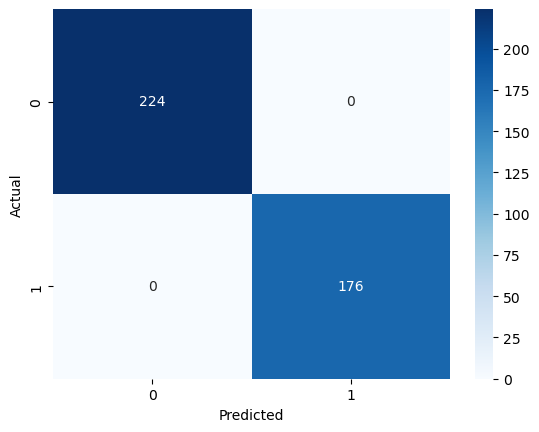

ROC-AUC: 1.0
PR-AUC: 1.0000000000000004
Brier score: 0.04170299770933686


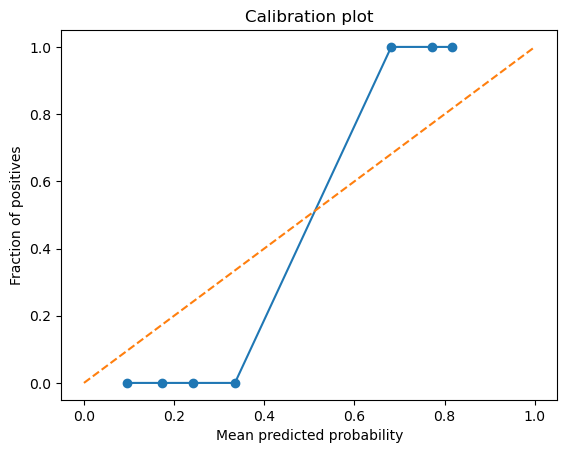

In [23]:
# Part 8: Evaluation on the test set
best_model.fit(X_train, y_train)
probs = best_model.predict_proba(X_test)[:,1]
preds = best_model.predict(X_test)

# Classification report
print(classification_report(y_test, preds))

# Confusion matrix
cm = confusion_matrix(y_test, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC-AUC and PR-AUC
print("ROC-AUC:", roc_auc_score(y_test, probs))
print("PR-AUC:", average_precision_score(y_test, probs))

# Brier score and calibration
print("Brier score:", brier_score_loss(y_test, probs))
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_test, probs, n_bins=10)
plt.figure()
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1],[0,1],'--')
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration plot")
plt.show()

> Part 9: Feature Importance (Random Forest only)

In this part, I look at which features are most important for my model’s predictions. I use the Random Forest’s built-in feature importance to see which variables the model relies on the most. I plot the top features to get a visual sense of what drives the loan approval predictions. This gives me insight into the model’s behavior and helps me understand which factors have the biggest impact on loan outcomes. It’s simpler than SHAP but still provides valuable guidance for feature analysis and decision-making.

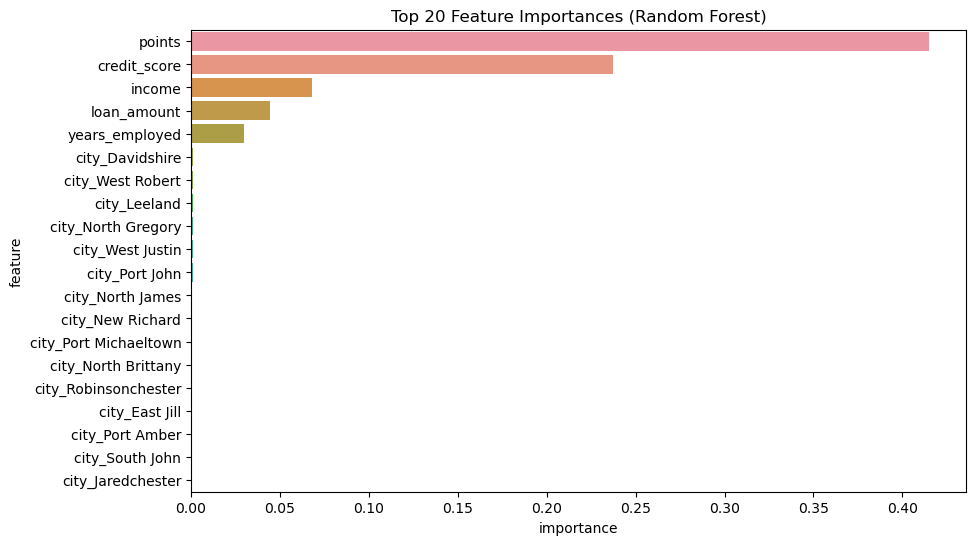

In [24]:
# Part 9: Feature Importance (Random Forest only)
importances = best_model.named_steps['model'].feature_importances_

# Get feature names after preprocessing
num_features = num_cols
cat_features = best_model.named_steps['pre'].named_transformers_['cat']['onehot'].get_feature_names_out(cat_cols)
all_features = np.concatenate([num_features, cat_features])

# Create a DataFrame for importance
feat_imp = pd.DataFrame({'feature': all_features, 'importance': importances})
feat_imp = feat_imp.sort_values(by='importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=feat_imp.head(20))
plt.title("Top 20 Feature Importances (Random Forest)")
plt.show()
